In [1]:
import numpy as np
import matplotlib.pyplot as plt
import calendar
import scipy as sp
import pandas as pd

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



**Note.** The quantile function $Q \colon [0, 1] \to \mathbb{R}$, given as input a probability $p$, returns a threshold value $x$ for which
$$
    \operatorname{Pr}(X \leq x) = p
$$
(where $X$ is the random variable in question). So, we are trying to find the value of the maximum wind speed for which there is only a 2% chance of obtaining a higher value.

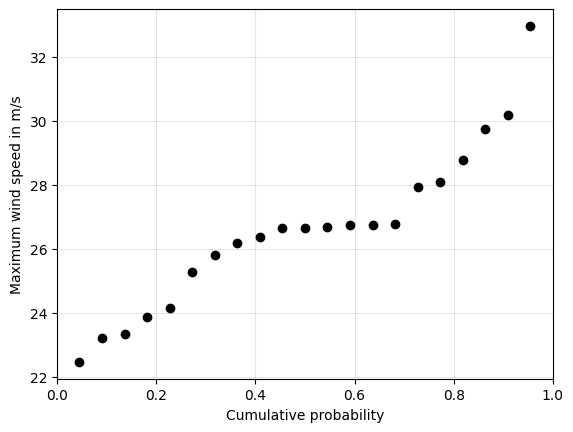

In [2]:
max_speeds = np.load("max-speeds.npy")
num_years = len(max_speeds)

# every maximum appears once, so its empirical probability is 1 / 21
# --> cumulative probability is i / (N + 1) with i = 1, ..., N + 1
cprob = (np.arange(1, num_years + 1)) / (num_years + 1)
sorted_max_speeds = np.sort(max_speeds)

plt.plot(cprob, sorted_max_speeds, 'ko')
plt.xlabel("Cumulative probability")
plt.ylabel("Maximum wind speed in m/s")
plt.grid(c='k', alpha=0.1)
plt.show()

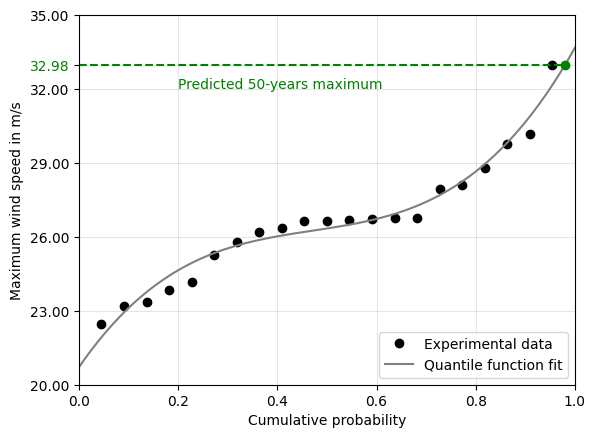

In [3]:
# a 3rd degree spline appears to fit the data good enough
quantile_func = sp.interpolate.UnivariateSpline(cprob, sorted_max_speeds, k=3)

# now construct the full quantile function array
prob_vals = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(prob_vals)

# get the maximum wind speed happening in 50 years
# in the current model we need 49 / 50 = 0.98 as input of quantile_func
fifty_prob = 0.98
fifty_max_speed = quantile_func(fifty_prob)

# plot everything
plt.plot(cprob, sorted_max_speeds, 'ko', label="Experimental data")
plt.plot(prob_vals, fitted_max_speeds, c='grey', label="Quantile function fit")
plt.axhline(y=fifty_max_speed, xmax=fifty_prob, linestyle='dashed', c='g')
plt.plot(fifty_prob, fifty_max_speed, 'go')
plt.xlim((0, 1))
plt.ylim((20, 35))

# add tick for the special value
ticks = [20, 23, 26, 29, 32, fifty_max_speed, 35]
plt.yticks(ticks)
plt.gca().get_yticklabels()[5].set_color('g')

plt.text(0.20, 32, rf"Predicted 50-years maximum", c='g')

plt.xlabel("Cumulative probability")
plt.ylabel("Maximum wind speed in m/s")
plt.legend()
plt.grid(c='k', alpha=0.1)
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

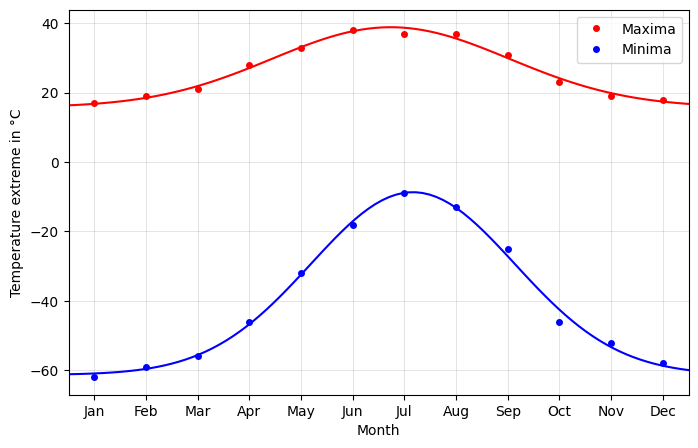

In [4]:
import calendar

def gauss_fitfunc(x, mu, var, norm, offset):
    return norm * np.exp(-0.5 * (x - mu)**2 / var) + offset

maxima = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
minima = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
month_num = list(range(0, 12))
months = [calendar.month_abbr[i + 1] for i in month_num]

max_par, _ = sp.optimize.curve_fit(gauss_fitfunc, month_num, maxima,
                                   p0=[7, 4, 5, 20])
min_par, _ = sp.optimize.curve_fit(gauss_fitfunc, month_num, minima,
                                   p0=[7, 4, 10, -60])

x = np.linspace(-1, 12, 100)

plt.figure(figsize=(8, 5))
plt.plot(months, maxima, 'ro', markersize=4, label="Maxima")
plt.plot(months, minima, 'bo', markersize=4, label="Minima")
plt.plot(x, gauss_fitfunc(x, *max_par), color='r')
plt.plot(x, gauss_fitfunc(x, *min_par), color='b')
plt.xlim((-0.5, 11.5))
plt.xlabel("Month")
plt.ylabel("Temperature extreme in °C")
plt.grid(c='k', alpha=0.1)
plt.legend()
plt.show()

In [5]:
comp = np.abs(max_par[0] - min_par[0]) / np.sqrt(max_par[1] + min_par[1])

print(f"Compatibility between the two means: {comp:.5f}")

Compatibility between the two means: 0.14158


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


Function value at min1: -1.03163
Function value at min2: -1.03163


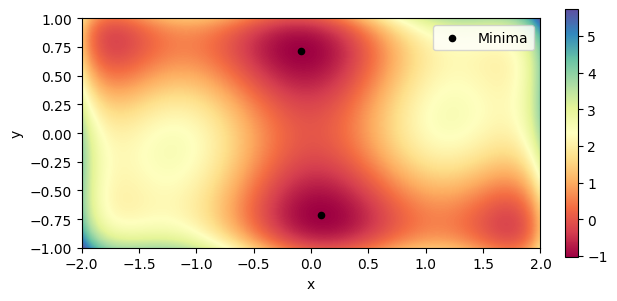

In [7]:
def f(x):
    x, y = x[0], x[1]
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * y + (4 * y**2 - 4) * y**2

bnds = ((-2, 2), (-1, 1))
domain = np.meshgrid(np.linspace(*bnds[0], 400), np.linspace(*bnds[1], 200))

min1 = sp.optimize.minimize(f, x0=(0, 0.75), bounds=bnds)
min2 = sp.optimize.minimize(f, x0=(0, -0.75), bounds=bnds)

print(f"Function value at min1: {f(min1.x):.5f}")
print(f"Function value at min2: {f(min2.x):.5f}")

plt.imshow(f(domain), origin='lower', extent=[-2, 2, -1, 1], cmap='Spectral')
plt.colorbar(fraction=0.025)
plt.scatter([min1.x[0], min2.x[0]], [min1.x[1], min2.x[1]], c='k', s=20, label='Minima')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [8]:
# if initial guess is (0, 0)
min_guess = sp.optimize.minimize(f, x0=(0, 0), bounds=bnds)

print(f"If the initial guess is (0, 0) minimize() returns {min_guess.x}")

If the initial guess is (0, 0) minimize() returns [0. 0.]


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

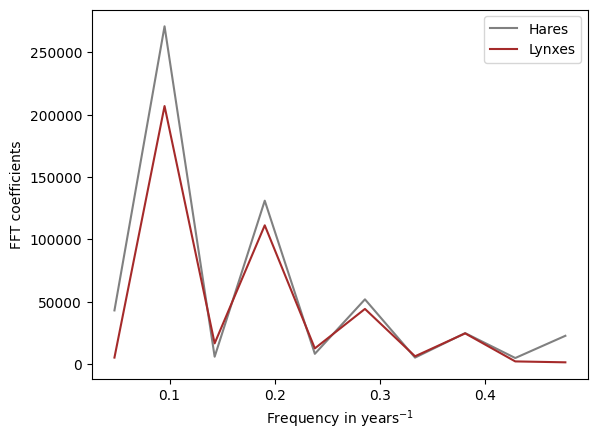

In [20]:
from scipy import fftpack

# load data from txt file
pop = pd.read_csv("populations.txt",
                  delimiter='\t', dtype=int, skiprows=1,
                  names=["year", "hares", "lynxes", "carrots"])

# fft frequencies
# d=1 because the time step is 1 year
freqs = fftpack.fftfreq(len(pop), d=1)
# limit to positive frequencies in the plot
mask = np.where(freqs > 0)
freqs = freqs[mask]
# ffts
hares_fft = np.abs(fftpack.fft(pop["hares"]))[mask]
lynxes_fft = np.abs(fftpack.fft(pop["lynxes"]))[mask]

# plot the fft coefficients
plt.plot(freqs, hares_fft, c="grey", label="Hares")
plt.plot(freqs, lynxes_fft, c="brown", label="Lynxes")
plt.xlabel(r"Frequency in $\mathrm{years}^{-1}$")
plt.ylabel("FFT coefficients")
plt.legend()
plt.show()


In [21]:
# find peak frequencies
hares_peak_freq = freqs[hares_fft.argmax()]
lynxes_peak_freq = freqs[lynxes_fft.argmax()]

print(f"Peak period in hares’ spectrum: {1 / hares_peak_freq} years")
print(f"Peak period in lynxes’ spectrum: {1 / lynxes_peak_freq} years")

Peak period in hares’ spectrum: 10.5 years
Peak period in lynxes’ spectrum: 10.5 years


5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

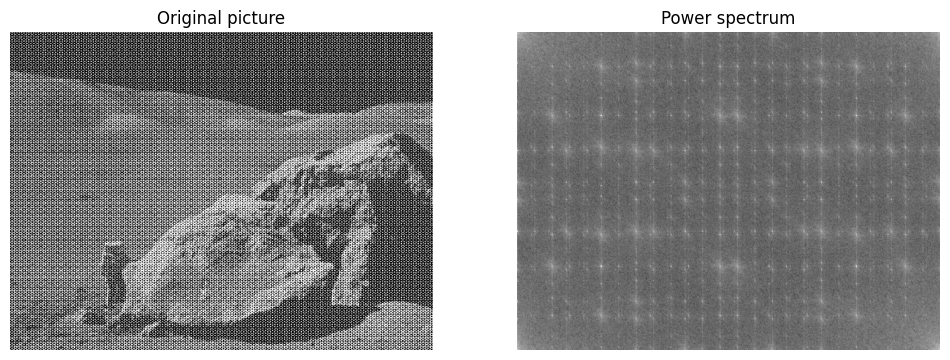

In [9]:
from matplotlib.colors import LogNorm

image = plt.imread('moonlanding.png')

spectrum = sp.fftpack.fft2(image)
power = np.abs(spectrum)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original picture")
ax[1].imshow(power, cmap='gray', norm=LogNorm(vmin=power.min(), vmax=power.max()))
ax[1].set_title("Power spectrum")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

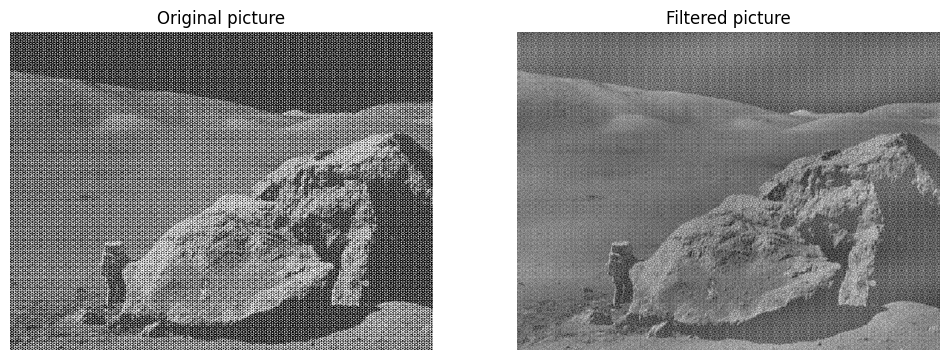

In [11]:
# clean up high frequencies
spectrum[power > 2700] = 0
filtered_image = sp.fftpack.ifft2(spectrum).real

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original picture")
ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title("Filtered picture")
ax[0].axis('off')
ax[1].axis('off')
plt.show()